# Binary integer programming

**This notebook: [see on github](https://github.com/csblab/PDBClean/blob/master/notebooks/Binary%20Integer%20Programming.ipynb) or [run on google colab](https://colab.research.google.com/github/csblab/PDBClean/blob/master/notebooks/Binary%20Integer%20Programming.ipynb)**

We are interested in a particular type of constrained optimization, where the objective function is linear or quadratic, the variable to solve is a binary integer that needs to satisfy a set of inequality constraints. 

see [this](http://www.sce.carleton.ca/faculty/chinneck/po/Chapter13.pdf), [this](https://nbviewer.jupyter.org/url/modernscientist.github.com/notebooks/BinaryIntegerProgramming.ipynb), [this](https://mathematica.stackexchange.com/questions/108299/given-a-large-binary-matrix-find-the-largest-submatrix-containing-non-zero-elem), and also [this](https://mathematica.stackexchange.com/questions/108299/given-a-large-binary-matrix-find-the-largest-submatrix-containing-non-zero-elem)





In [1]:
import numpy as np

In [2]:
import cvxopt
from cvxopt import glpk
from cvxopt import matrix

In [3]:
help(glpk.ilp)

Help on built-in function ilp in module cvxopt.glpk:

ilp(...)
    Solves a mixed integer linear program using GLPK.
    
    (status, x) = ilp(c, G, h, A, b, I, B)
    
    PURPOSE
    Solves the mixed integer linear programming problem
    
        minimize    c'*x
        subject to  G*x <= h
                    A*x = b
                    x[k] is integer for k in I
                    x[k] is binary for k in B
    
    ARGUMENTS
    c            nx1 dense 'd' matrix with n>=1
    
    G            mxn dense or sparse 'd' matrix with m>=1
    
    h            mx1 dense 'd' matrix
    
    A            pxn dense or sparse 'd' matrix with p>=0
    
    b            px1 dense 'd' matrix
    
    I            set of indices of integer variables
    
    B            set of indices of binary variables
    
    status       if status is 'optimal', 'feasible', or 'undefined',
                 a value of x is returned and the status string 
                 gives the status of x.  Other po

## Application to our problem

We are given a binary matrix $A$ for `n_sample (n)` samples with `n_feature (m)` features, with elements $a_{ij}$, where $a_{ij}$ is 1 if the feature is present in the sample, and zero otherwise.

We want to determine the values of the following variables ($i \in [1,m]$ and $j \in [1,n]$), all $\in {0,1}$:
- $e_{ij}$: it is $1$ if we want to remove $(i,j)$, else it is $0$
- $r_{i}$: it is $1$ if we remove row $i$, else it is $0$
- $c_{j}$: it is $1$ if we remove column $j$, else it is $0$

subject to:
- $a_{ij} = 0 \implies e_{ij}=1$
- $r_{i} + c_{j} \ge e_{ij}$
- $e_{ij} \ge r_{i}$
- $e_{ij} \ge c_{j}$

minimizing the objective function $Z = \sum_{ij}\ e_{ij}$.

Let's package this problem so we can solve it with `glpk.ilp`:

We introduce the vectors:
- $r = \{r_{i}\}_{m}$
- $c = \{c_{j}\}_{n}$
- $e = \{e_{ij}\}_{m\times n}$

$x^{T} = [r^{T}, c^{T}, e^{T}]$

$w^{T} = [\{0\}_{m},\{0\}_{n},\{1\}_{m\times n}]$

So that the score function is $Z = w^{T}x$

**before proceeding, run the Toolkit cells at the end of this notebook!**

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

Let's build a m/n_feature-by-n/n_sample binary matrix with n_zeros zeros randomly located

A.shape = (50, 10)


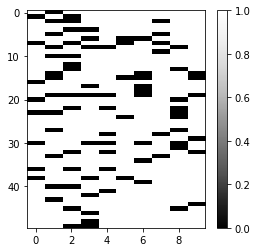

In [7]:
n=10
m=50
n_zeros=100
A = build_A(n_sample=n,n_feature=m, n_zeros=n_zeros)
show_matrix(A)

Now let's build the $G$ matrix for each of our 4 constraints. 
We first define $G$ and $h$ as if the problem was $\mathbf{G}\mathbf{x} \geq \mathbf{h}$, and multiply them by $-1$ at the end to frame the problem as $\mathbf{G}\mathbf{x} \leq \mathbf{h}$ so it can be solved by `glpk`. All G matrices are the concatenation of $G_r$, $G_c$ and $G_e$ matrices. All have $m\times n$ rows, corresponding to the constraints, and as many column as their respective unknown variable ($m$ for $r$, $n$ for $c$ amd $m\times n$ for $e$).

First constraint $\mathbf{G}_{1}\mathbf{x} \geq \mathbf{h}_{1}$: we set $\mathbf{h}_{1}$ to $0$ everywhere except when (flattened) $\mathbf{A}$ is zero, then we set $\mathbf{h}_{1}$ to $1$. $\mathbf{G}_{r}$ and $\mathbf{G}_{c}$ are zeros, and $\mathbf{G}_{e}$ is the identity matrix.

... Gr built
... Gc built
... Ge built
G.shape = (500, 560)
h.shape = (500,)


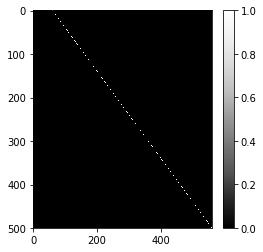

In [8]:
G1 = build_G(A, constraint=1)
h1 = build_h(A, constraint=1)
show_matrix(G1)

Second constraint $\mathbf{G}_{2}\mathbf{x} \geq \mathbf{h}_{2}$: we set $\mathbf{h}_{2}$ to $0$ everywhere. $\mathbf{G}_{r}$ is zero except for $i$ and $\mathbf{G}_{c}$ is a series of $m$ $n\times n$ identity matrices, and $\mathbf{G}_{e}$ is the identity matrix multiplied by $-1$.

... Gr built
... Gc built
... Ge built
G.shape = (500, 560)
h.shape = (500,)


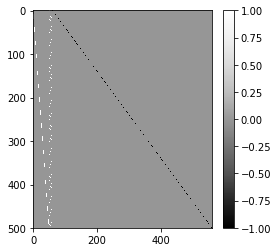

In [9]:
G2 = build_G(A, constraint=2)
h2 = build_h(A, constraint=2)
show_matrix(G2)

Third constraint $\mathbf{G}_{3}\mathbf{x} \geq \mathbf{h}_{3}$: we set $\mathbf{h}_{3}$ to $0$ everywhere. $\mathbf{G}_{r}$ is zero except for $i$ where it is -1, $\mathbf{G}_{c}$ is $0$ everywhere and $\mathbf{G}_{e}$ is the identity matrix.

... Gr built
... Gc built
... Ge built
G.shape = (500, 560)
h.shape = (500,)


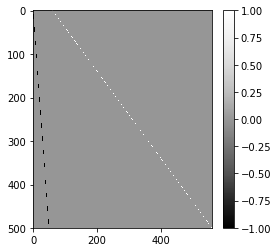

In [10]:
G3 = build_G(A, constraint=3)
h3 = build_h(A, constraint=3)
show_matrix(G3)

Fourth constraint $\mathbf{G}_{4}\mathbf{x} \geq \mathbf{h}_{4}$: we set $\mathbf{h}_{4}$ to $0$ everywhere. $\mathbf{G}_{r}$ is zero everywhere, $\mathbf{G}_{c}$ is a series of $m$ $n\times n$ identity matrices multiplied by $-1$ and $\mathbf{G}_{e}$ is the identity matrix.

... Gr built
... Gc built
... Ge built
G.shape = (500, 560)
h.shape = (500,)


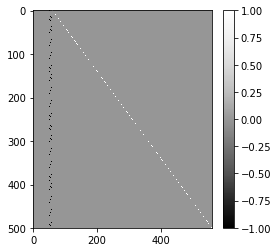

In [11]:
G4 = build_G(A, constraint=4)
h4 = build_h(A, constraint=4)
show_matrix(G4)

We now assemble the full $G$ matrix and $h$ vector, as well as build the weight vector for the score function.

In [29]:
G = assemble_G(A,G1,G2,G3,G4)
h = assemble_h(A,h1,h2,h3,h4)
w = assemble_w(A)

G.shape = (2000, 560)
h.shape = (2000,)
w.shape = (560,)


Call the solver

In [30]:
c, G, h = matrix(w), matrix(G.T), matrix(h)
status, sol = glpk.ilp(c, G.T, h, B=set(range(len(c))))
solution = np.array(sol)
solution_row = solution[0:m]
solution_col = solution[m:m+n]
solution_mat = solution[m+n:].reshape((m,n))
print('Solution is {0}. Score went from {1} to {2}. We keep {3} samples and {4} features.'.format(status, np.sum(1-A), int(np.sum(1-solution_mat)), int(np.sum(1-solution_col)), int(np.sum(1-solution_row))))

Solution is optimal. Score went from 90 to 132. We keep 6 samples and 22 features.


Let's see what the initial and optimized $A$ matrix look like:

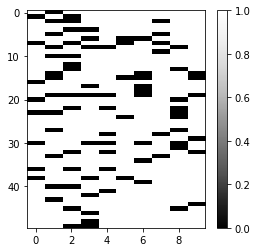

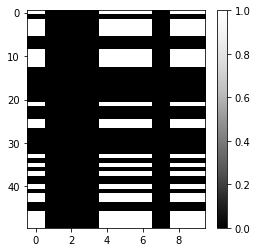

In [31]:
show_matrix(A)
show_matrix(1-solution_mat)

Let's see what would have happened if we wanted to minimize the number of discarded samples:

G.shape = (2000, 560)
h.shape = (2000,)
w.shape = (560,)
Solution is optimal. Score went from 90 to 80. We keep 10 samples and 8 features.


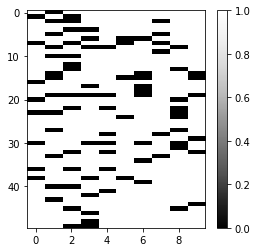

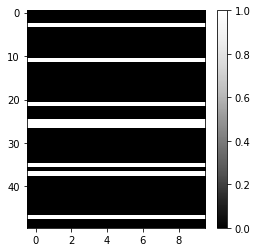

In [33]:
G = assemble_G(A,G1,G2,G3,G4)
h = assemble_h(A,h1,h2,h3,h4)
w = assemble_w(A, mode='c')
c, G, h = matrix(w), matrix(G.T), matrix(h)
status, sol = glpk.ilp(c, G.T, h, B=set(range(len(c))))
solution = np.array(sol)
solution_row = solution[0:m]
solution_col = solution[m:m+n]
solution_mat = solution[m+n:].reshape((m,n))
print('Solution is {0}. Score went from {1} to {2}. We keep {3} samples and {4} features.'.format(status, np.sum(1-A), int(np.sum(1-solution_mat)), int(np.sum(1-solution_col)), int(np.sum(1-solution_row))))
show_matrix(A)
show_matrix(1-solution_mat)

Now if we decided to minimize the number of discarded features:

G.shape = (2000, 560)
h.shape = (2000,)
w.shape = (560,)
Solution is optimal. Score went from 90 to 0. We keep 0 samples and 50 features.


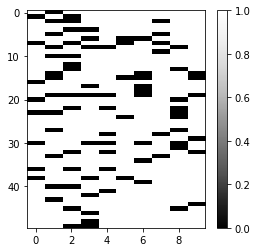

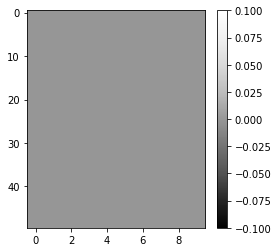

In [34]:
G = assemble_G(A,G1,G2,G3,G4)
h = assemble_h(A,h1,h2,h3,h4)
w = assemble_w(A, mode='r')
c, G, h = matrix(w), matrix(G.T), matrix(h)
status, sol = glpk.ilp(c, G.T, h, B=set(range(len(c))))
solution = np.array(sol)
solution_row = solution[0:m]
solution_col = solution[m:m+n]
solution_mat = solution[m+n:].reshape((m,n))
print('Solution is {0}. Score went from {1} to {2}. We keep {3} samples and {4} features.'.format(status, np.sum(1-A), int(np.sum(1-solution_mat)), int(np.sum(1-solution_col)), int(np.sum(1-solution_row))))
show_matrix(A)
show_matrix(1-solution_mat)

Let's try some in-between ?

G.shape = (2000, 560)
h.shape = (2000,)
w.shape = (560,)
Solution is optimal. Score went from 90 to 130. We keep 5 samples and 26 features.


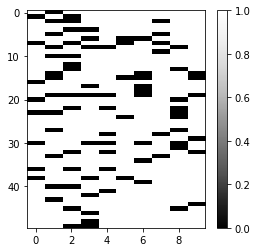

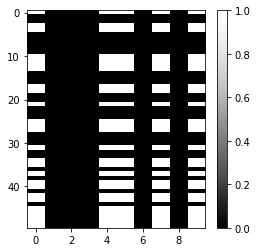

In [35]:
G = assemble_G(A,G1,G2,G3,G4)
h = assemble_h(A,h1,h2,h3,h4)
w = assemble_w(A, mode='all')
c, G, h = matrix(w), matrix(G.T), matrix(h)
status, sol = glpk.ilp(c, G.T, h, B=set(range(len(c))))
solution = np.array(sol)
solution_row = solution[0:m]
solution_col = solution[m:m+n]
solution_mat = solution[m+n:].reshape((m,n))
print('Solution is {0}. Score went from {1} to {2}. We keep {3} samples and {4} features.'.format(status, np.sum(1-A), int(np.sum(1-solution_mat)), int(np.sum(1-solution_col)), int(np.sum(1-solution_row))))
show_matrix(A)
show_matrix(1-solution_mat)

## Conclusion

We could get even more creative on the scoring function, but it's seems that minimizing the number of discarded elements under the constraints that an element removed removes all elements from its row and column, works pretty well!

## Toolkit

In [4]:
def build_A(n_sample=5, n_feature=20, n_zeros=10):
    A = np.ones((n_feature*n_sample)).astype('int')
    index = np.random.randint(0,high=A.shape[0], size=n_zeros)
    A[index] = 0
    A = np.reshape(A, (n_feature,n_sample))
    print('A.shape = {0}'.format(A.shape))
    return A

def assemble_w(A, mode='e'):
    """
    """
    m, n = A.shape
    if(mode=='all'):
        wr = 1
        wc = 1
        we = 1
    else:
        wr = 0
        if(mode=='r'):
            wr=1
        wc = 0
        if(mode=='c'):
            wc=1
        we = 0
        if(mode=='e'):
            we=1
    w = np.empty(n+m+n*m)
    w[0:m]   = wr
    w[m:m+n] = wc
    w[n+m:n+m+n*m] = we
    print('w.shape = {0}'.format(w.shape))
    return w.astype('double')

def assemble_h(A,h1,h2,h3,h4):
    """
    """
    m, n = A.shape
    nrows = m*n
    h = np.empty(4*nrows)
    h[0:nrows]         = h1
    h[nrows:2*nrows]   = h2
    h[2*nrows:3*nrows] = h3
    h[3*nrows:4*nrows] = h4
    print('h.shape = {0}'.format(h.shape))
    return -h.astype('double')

def assemble_G(A,G1,G2,G3,G4):
    """
    """
    m, n = A.shape
    nrows = m*n
    ncols = m + n + m*n
    G = np.empty((4*nrows,ncols))
    G[0:nrows,:]         = G1
    G[nrows:2*nrows,:]   = G2
    G[2*nrows:3*nrows,:] = G3
    G[3*nrows:4*nrows,:] = G4
    print('G.shape = {0}'.format(G.shape))
    return -G.astype('double')

def build_h(A, constraint=1): #n_sample=5, n_feature=20):
    """
    """
    m, n = A.shape
    nrows = m*n
    if(constraint==1):
        h = np.invert(A.reshape(nrows).astype('bool')).astype('int')
    else:
        h = np.zeros(nrows)
    print('h.shape = {0}'.format(h.shape))
    return h

def build_G(A, constraint=1):
    """
    """
    m, n = A.shape
    nrows = m*n
    ncols = m + n + m*n
    Gr = build_Gr(m,n,constraint=constraint)
    Gc = build_Gc(m,n,constraint=constraint)
    Ge = build_Ge(m,n,constraint=constraint)
    G  = np.zeros((nrows,ncols))
    G[:,0:m]   = Gr
    G[:,m:m+n] = Gc
    G[:,m+n:]  = Ge
    print('G.shape = {0}'.format(G.shape))
    return G

def build_Gr(m,n,constraint=1):
    nrows = m*n
    Gr = np.zeros((nrows,m))
    if(constraint==2):
        for i in np.arange(m):
            Gr[i*n:(i+1)*n,i] = 1
    elif(constraint==3):
        for i in np.arange(m):
            Gr[i*n:(i+1)*n,i] = -1
    print('... Gr built')
    return Gr
        
def build_Gc(m,n,constraint=1):
    nrows = m*n
    Gc = np.zeros((nrows,n))
    if(constraint==2):
        for i in np.arange(m): 
            Gc[i*n:(i+1)*n,:] = np.identity(n)
    elif(constraint==4):
        for i in np.arange(m):
            Gc[i*n:(i+1)*n,:] = -np.identity(n)
    print('... Gc built')
    return Gc

def build_Ge(m,n,constraint=1):
    nrows = m*n
    Ge = np.identity(nrows)
    if(constraint==2):
        Ge = -Ge
    print('... Ge built')
    return Ge
    

In [5]:
def show_matrix(X, cmap='Greys_r', figsize=(4,4)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(X, cmap=cmap, aspect='auto')
    plt.colorbar()
    plt.show()